# Pipeline

In [1]:
import lovely_tensors as lt
lt.monkey_patch()

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

In [3]:
from spellbook import count_parameters

In [4]:
def get_cameraman_tensor(sidelength):
    pil_img = Image.fromarray(skimage.data.camera())        
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(pil_img)
    return img, pil_img

In [5]:
class ImageFitting(Dataset):
    def __init__(self, sidelength):
        super().__init__()
        img, pil_img = get_cameraman_tensor(sidelength)
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)
        self.pil_img = pil_img

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
            
        return self.coords, self.pixels

In [6]:
import os
import random
import numpy as np
import torch

def seed_all(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [7]:
def mse_and_psnr(im_a, im_b, data_range=1): 
    data_range = 1.
    mse = F.mse_loss(im_a, im_b)
    psnr = 10 * torch.log10((data_range ** 2) / mse)
    return mse, psnr

from pathlib import Path; Path.ls = lambda x: list(x.iterdir())

def get_uvs(H, W, device='cpu'):
    xs = torch.linspace(-1, 1, W).to(device)
    ys = torch.linspace(-1, 1, H).to(device)

    x, y = torch.meshgrid(xs, ys, indexing='xy')
    uvs = torch.stack([x,y], dim=-1)
    return uvs

In [8]:
def load_data(cfg):
    if cfg.image == 'cameraman':
        cameraman = ImageFitting(256)
        dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)    
        model_input, ground_truth = next(iter(dataloader))
        W,H = 256,256

    else:
        image_path = Path(cfg.image_dir) / cfg.image
        assert image_path.exists()

        image_pil = Image.open(image_path)
        W, H = image_pil.size
        
        desired_W = cfg.get('image_W')
        if desired_W:    
            aspect = H/W
            W = desired_W

            H = int( W * aspect )
            image_pil = image_pil.resize((W,H))


        image = torch.tensor(np.asarray(image_pil)).permute(2,0,1)/255

        # to verify:
        # F.grid_sample(image[None], uvs[None]).rgb
        uvs = get_uvs(H, W, device='cpu')
        model_input, ground_truth = uvs.reshape(1, -1, 2), image.reshape(1, -1, 3)


    return model_input, ground_truth, H, W

In [9]:
def to01(t):
    t = t - t.min()
    t = t / t.max()
    return t

In [10]:
def tensor2pil(t):
    return Image.fromarray((t.detach().permute(1,2,0).cpu().clip(0, 1).numpy()*255).astype(np.uint8))

def pil2tensor(pil): return torch.tensor(
    np.asarray(pil).astype(np.float32)/255).permute(2, 0, 1)


def imagify_tensor(t, H, W): 
    return tensor2pil(to01( t.reshape(-1, H, W).expand(3, H, W) ))

# cfg

In [11]:
import os
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf


def load_cfg(overrides=()):
    # with initialize_config_dir(config_dir="/app/notebooks/draft_02/conf"):
    with initialize(version_base=None, config_path="./conf"):
        cfg = compose(config_name='config', overrides=list(overrides))
        return cfg

In [12]:
cfg = load_cfg()
print(OmegaConf.to_yaml(cfg))

image: sasha.jpg
image_dir: ../../data
image_W: 512
use_wandb: true
is_debug: false
random_seed:
- 0
- 1
- 2
- 3
- 4
model:
  _target_: spellbook.siren.model.Siren
  in_features: 2
  out_features: none
  hidden_features: 256
  hidden_layers: 3
  init_c: 6
  first_layer_init_c: 1
  outermost_linear: true
logging:
  logger:
    _target_: spellbook.logging.wandb.WandbLogger
    project: 01_splitnet__${image}
  steps_till_summary: 500
optimizer:
  _target_: torch.optim.AdamW
  weight_decay: 0.0
  lr: 0.0001



In [13]:
def _train_seed(cfg, random_seed=0):
    seed_all(random_seed)
    print('Setting seed to', random_seed)
    is_debug = cfg.get('is_debug')

    project = cfg.logging.logger.project

    if is_debug:
        project = 'DEBUG__'+project
        
    
    logger = instantiate(
        cfg.logging.logger,
        project=project,
        group=cfg.logging.experiment_name,
        name=f'rs{random_seed}',
    )
    
    print(OmegaConf.to_yaml(cfg))

    device = cfg['device']

    model_input, ground_truth, H, W = load_data(cfg)
    model_input, ground_truth = model_input.to(device), ground_truth.to(device)

    out_features = ground_truth.shape[-1]
    model = instantiate(cfg['model'], out_features=out_features)
    model.to(device);

    total_steps = cfg['total_steps']
    steps_til_summary = cfg.logging['steps_till_summary']

    total_params = count_parameters(model)


    logger.log_dict({'total_params': total_params})

    optimizer = instantiate(cfg.optimizer, params=model.parameters())

    for step in range(total_steps):
        model_output = model(model_input)
        mse, psnr = mse_and_psnr(model_output, ground_truth)
        loss = mse

        log_dic = {'step': step, 'mse': mse.item(), 'psnr': psnr.item()}
        logger.log_dict(log_dic)

        if not step % steps_til_summary:
            print(f"Step {step}, Total loss {loss:0.6f}")
            # img_grad_tensor = gradient(model_output, coords)
            # img_laplacian_tensor = laplace(model_output, coords)

            img = imagify_tensor(model_output, H, W)
            # img_grad = imagify_tensor(img_grad_tensor.norm(dim=-1))
            # img_laplacian = imagify_tensor(img_laplacian_tensor)

            colage = img
            plt.imshow(colage)
            plt.show()

            logger.log_image(colage, name='pred_image')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [14]:
# cfg = load_cfg(overrides=[
#     "+exp=00_siren_init",
#     "+device=cuda:1"
# ])
    
# _train_seed(cfg, random_seed=42)

In [15]:
def train(cfg):
    for random_seed in cfg.random_seed:
        _train_seed(cfg, random_seed=random_seed)

Setting seed to 0


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kilianovski. Use `wandb login --relogin` to force relogin


image: sasha.jpg
image_dir: ../../data
image_W: 512
use_wandb: true
is_debug: false
random_seed:
- 0
- 1
- 2
- 3
- 4
model:
  _target_: spellbook.siren.model.Siren
  in_features: 2
  out_features: none
  hidden_features: 256
  hidden_layers: 3
  init_c: 6
  first_layer_init_c: 0.1
  outermost_linear: true
logging:
  logger:
    _target_: spellbook.logging.wandb.WandbLogger
    project: 01_splitnet__${image}
  steps_till_summary: 500
  experiment_name: siren_init__initc=${model.init_c}__flic=${model.first_layer_init_c}
optimizer:
  _target_: torch.optim.AdamW
  weight_decay: 0.0
  lr: 0.0001
total_steps: 3000
device: cuda:1

+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
| net.0.linear.weight |    512     |
|  net.0.linear.bias  |    256     |
| net.1.linear.weight |   65536    |
|  net.1.linear.bias  |    256     |
| net.2.linear.weight |   65536    |
|  net.2.linear.bias  |    256     |
| net.3.linear.weight |   65536    

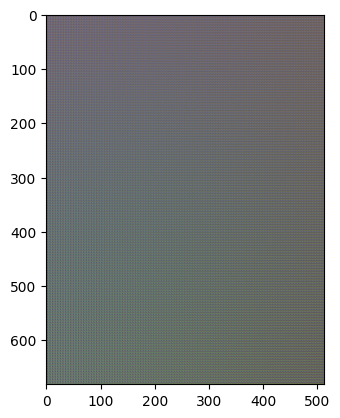

Step 500, Total loss 0.006278


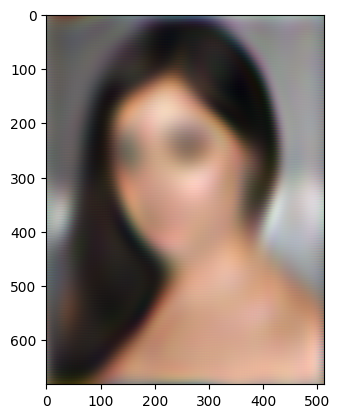

In [ ]:
first_layer_init_c_sweep = [0.1, 0.5, 1., 2., 4., 16.]

for first_layer_init_c in first_layer_init_c_sweep:
    cfg = load_cfg(overrides=[
        "+exp=00_siren_init", 
        f"model.first_layer_init_c={first_layer_init_c}",
        "+device=cuda:1"
    ])
    
    train(cfg)

In [ ]:
init_c_sweep = [1,3,6,12,24,42,64]

for init_c in init_c_sweep:
    cfg = load_cfg(overrides=[
        "+exp=00_siren_init", 
        f"model.init_c={init_c}",
        "+device=cuda:1"
    ])
    
    train(cfg)